#  Get dataset with localized objects to work with

### Download dataset for selected classes

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    # split="validation",
    # label_types=["detections", "segmentations"], # By default it downloads only
    classes=["banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake"],
    # max_samples=50,
)


Found annotations at 'C:\Users\salamander\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at 'C:\Users\salamander\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Test split is unlabeled; ignoring classes requirement
Found test info at 'C:\Users\salamander\fiftyone\coco-2017\raw\image_info_test2017.json'
Images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'coco-2017'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### filter only desired samples from downloaded files

In [4]:
from fiftyone import ViewField as F
food_view = dataset.filter_labels(
    "ground_truth",
    F("label").is_in(["banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake"])
)


### start a session to explore the data

In [5]:
# session = fo.launch_app(dataset)
# session = fo.launch_app(food_view)

## Preview dataset outside of fiftyone UI

In [6]:
import matplotlib.pyplot as plt
sample = food_view.first()
print(sample.field_names)
sample.ground_truth

('id', 'filepath', 'tags', 'metadata', 'ground_truth')


<Detections: {
    'detections': [
        <Detection: {

            'id': '66a50e0b4645cea80c8574e2',

            'attributes': {},

            'tags': [],

            'label': 'broccoli',

            'bounding_box': [

                0.39,

                0.4776458333333334,

                0.49412500000000004,

                0.5105833333333334,

            ],

            'mask': None,

            'confidence': None,

            'index': None,

            'supercategory': 'food',

            'iscrowd': 0,

        }>,
        <Detection: {

            'id': '66a50e0b4645cea80c8574e4',

            'attributes': {},

            'tags': [],

            'label': 'orange',

            'bounding_box': [0.5878125, 0.08408333333333333, 0.118046875, 0.0969375],

            'mask': None,

            'confidence': None,

            'index': None,

            'supercategory': 'food',

            'iscrowd': 0,

        }>,
        <Detection: {

            'id': '66a50e

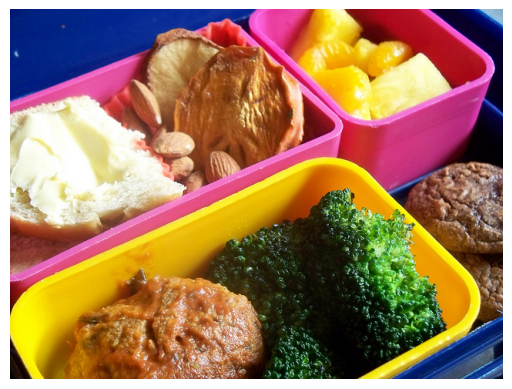

In [7]:
import matplotlib.pyplot as plt

# Get the image path from the sample
image_path = sample.filepath

# Load and display the image
image = plt.imread(image_path)
plt.imshow(image)
plt.axis("off")
plt.show()

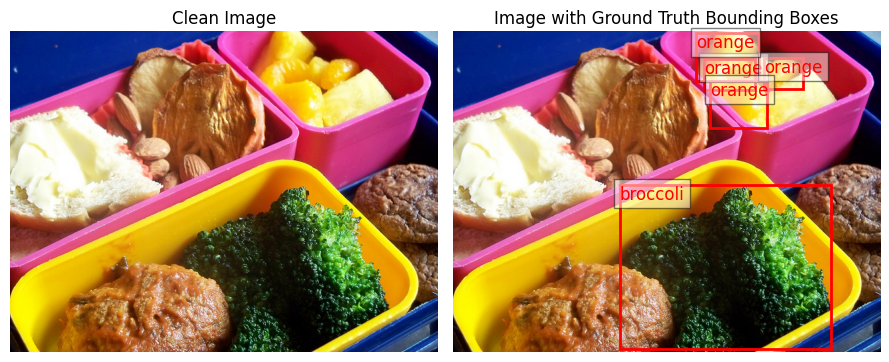

In [8]:
def preview_sample(sample, figsize=(9, 4)):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Assuming you have the sample object named `sample`

    # Get the image path
    image_path = sample.filepath

    # Get the ground truth detections
    ground_truth_detections = sample.ground_truth.detections

    # Create a new figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot the clean image
    image = plt.imread(image_path)
    ax1.imshow(image)
    ax1.set_title("Clean Image")
    ax1.axis("off")

    # Plot the image with ground truth bounding boxes
    ax2.imshow(image)

    # Iterate over the ground truth detections and draw bounding boxes
    for detection in ground_truth_detections:
        label = detection.label
        bbox = detection.bounding_box

        # Extract bounding box coordinates
        x, y, w, h = bbox

        # Create a Rectangle patch
        rect = patches.Rectangle((x * image.shape[1], y * image.shape[0]), 
                                w * image.shape[1], h * image.shape[0],
                                linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the plot
        ax2.add_patch(rect)

        # Add label text
        ax2.text(x * image.shape[1], y * image.shape[0], label, color='r', fontsize=12, 
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Set the title and remove the axis labels
    ax2.set_title("Image with Ground Truth Bounding Boxes")
    ax2.axis("off")

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
preview_sample(sample)

# Select and prepare them do desired format to create POC with known architecture

In [9]:
pizza_dataset = food_view.filter_labels(
    "ground_truth",
    F("label").is_in(["pizza"])
)

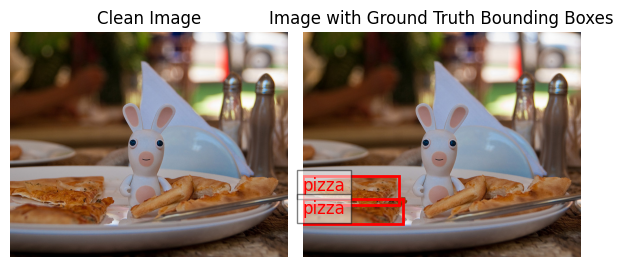

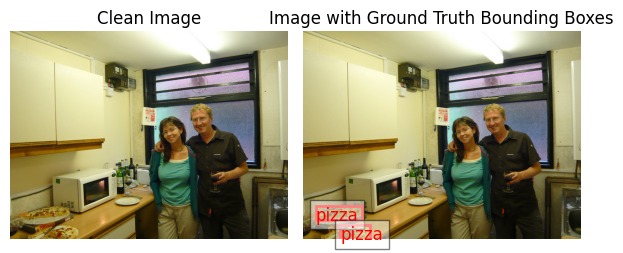

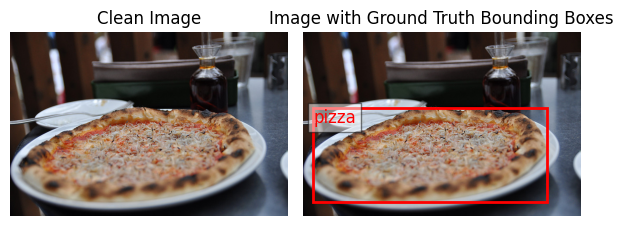

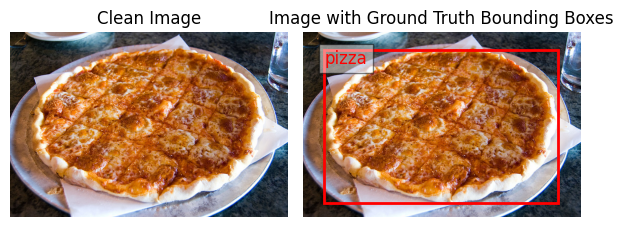

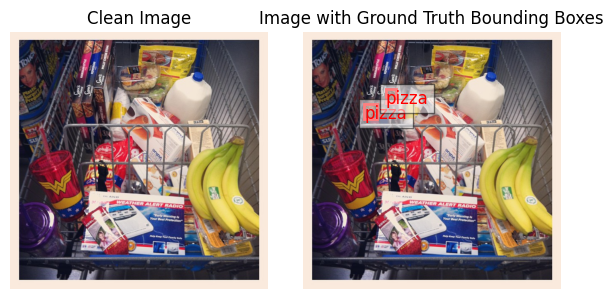

In [10]:
for pizza_sample in pizza_dataset.tail(5):
    preview_sample(pizza_sample, figsize=(6, 3))

In [11]:
len(pizza_dataset)

1890

### Multiple labels on same image
- As we can see on samples above - we have multiple pizza boxes on same picture. 
- It is more complex than our previous network that works with recognizing single class
- To get closer ro task complexity (assuming we want to work with previous network) we need to limit it somehow

In [12]:
from fiftyone import ViewField as F

# --------------------------------------------------------------
# Pick first pizza label from ground_truth for each sample
# --------------------------------------------------------------
pizza_set_one_label_1 = (
    pizza_dataset
    .filter_labels("ground_truth", F("label") == "pizza")
    .limit_labels("ground_truth", 1)
)
print('pizza_set_one_label_1: ', len(pizza_set_one_label_1))

# --------------------------------------------------------------
# Filter only isamples with exactly 1 pizza label from the start
# --------------------------------------------------------------
pizza_set_one_label_2 = pizza_dataset.match(F("ground_truth.detections").filter(F("label") == "pizza").length() == 1)
print('pizza_set_one_label_2: ', len(pizza_set_one_label_2))

# --------------------------------------------------------------
# Select biggest label for each image
# --------------------------------------------------------------
def select_largest_box(sample, box_class):
    detections = [d for d in sample.ground_truth.detections if d.label == box_class]
    if detections:
        largest_box = max(detections, key=lambda d: d.bounding_box[2] * d.bounding_box[3])
        sample.ground_truth.detections = [largest_box]
    else:
        print(f"There is no {box_class} in the image {sample.filename}!")
    return sample

pizza_set_one_label_3 = fo.Dataset()
for sample in pizza_dataset:
    new_sample = select_largest_box(sample.copy(), box_class="pizza")
    pizza_set_one_label_3.add_sample(new_sample)

print('pizza_set_one_label_3: ', len(pizza_set_one_label_3))

pizza_set_one_label_1:  1890
pizza_set_one_label_2:  1090
pizza_set_one_label_3:  1890


In [13]:
# for pizza_sample in pizza_dataset.head(15):
#     preview_sample(pizza_sample, figsize=(6, 3))

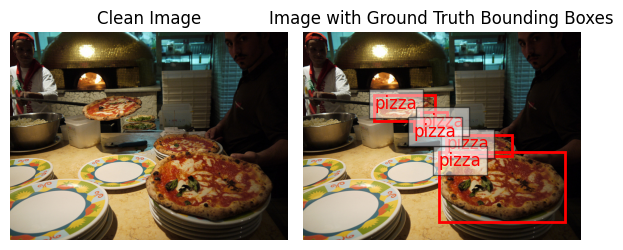

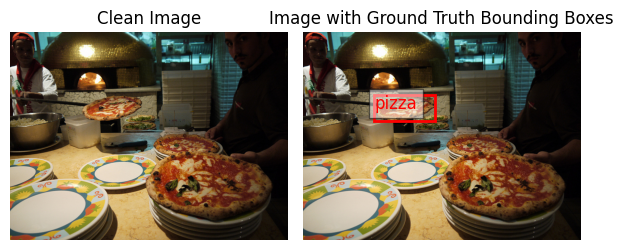

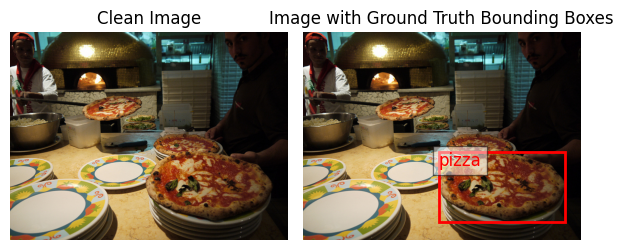

In [14]:
# for pizza_sample in 
preview_sample(pizza_dataset.skip(5).first(), figsize=(6, 3))
preview_sample(pizza_set_one_label_1.skip(5).first(), figsize=(6, 3))
# preview_sample(pizza_set_one_label_2.skip(5).first(), figsize=(6, 3)) # This one will have different ID as it skips this sample
preview_sample(pizza_set_one_label_3.skip(5).first(), figsize=(6, 3))

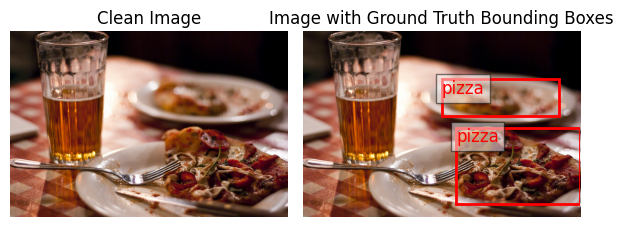

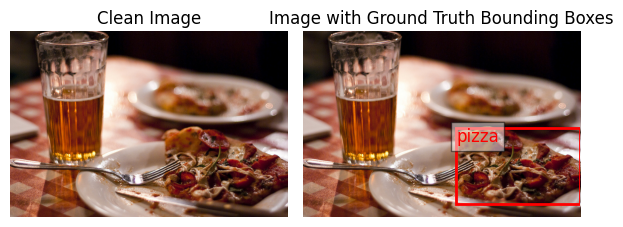

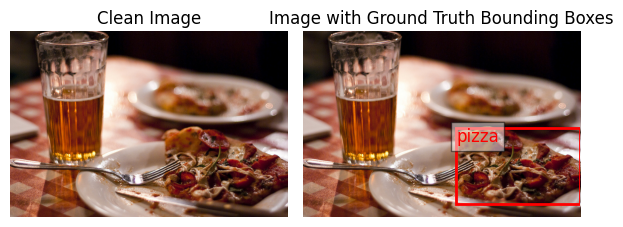

In [15]:
# for pizza_sample in 
preview_sample(pizza_dataset.skip(6).first(), figsize=(6, 3))
preview_sample(pizza_set_one_label_1.skip(6).first(), figsize=(6, 3))
# preview_sample(pizza_set_one_label_2.skip(6).first(), figsize=(6, 3)) # This one will have different ID as it skips this sample
preview_sample(pizza_set_one_label_3.skip(6).first(), figsize=(6, 3))

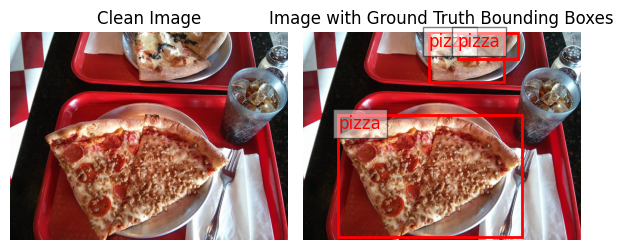

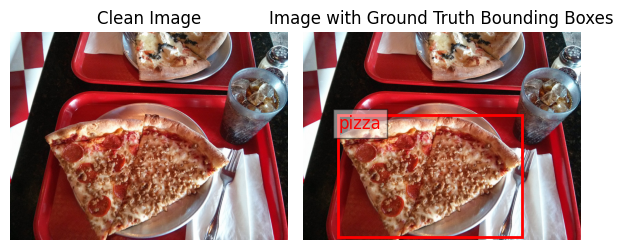

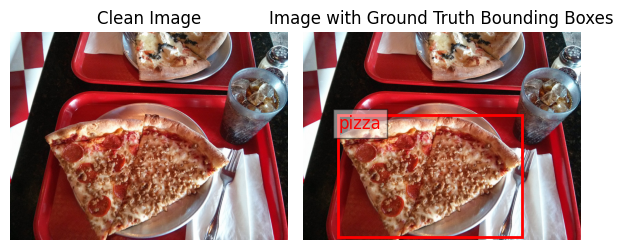

In [16]:
# for pizza_sample in 
sample_num = 19
preview_sample(pizza_dataset.skip(sample_num).first(), figsize=(6, 3))
preview_sample(pizza_set_one_label_1.skip(sample_num).first(), figsize=(6, 3))
# preview_sample(pizza_set_one_label_2.skip(sample_num).first(), figsize=(6, 3)) # This one will have different ID as it skips this sample
preview_sample(pizza_set_one_label_3.skip(sample_num).first(), figsize=(6, 3))

### Get some other class to let model choose between them

In [17]:
sandwich_dataset = food_view.filter_labels(
    "ground_truth",
    F("label").is_in(["sandwich"])
)


sandwich_dataset_one_label = fo.Dataset()
for sample in sandwich_dataset:
    new_sample = select_largest_box(sample.copy(), box_class="sandwich")
    sandwich_dataset_one_label.add_sample(new_sample)

print('sandwich_dataset_one_label: ', len(sandwich_dataset_one_label))

sandwich_dataset_one_label:  2463


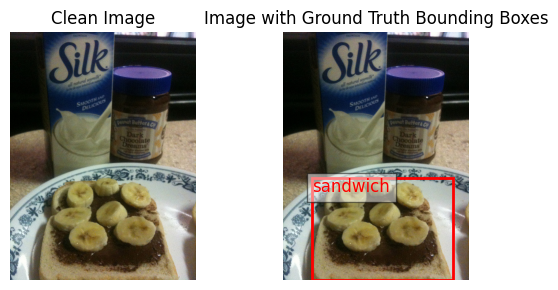

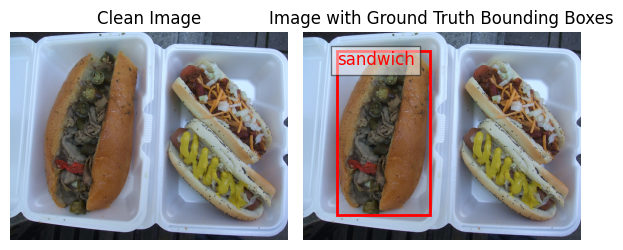

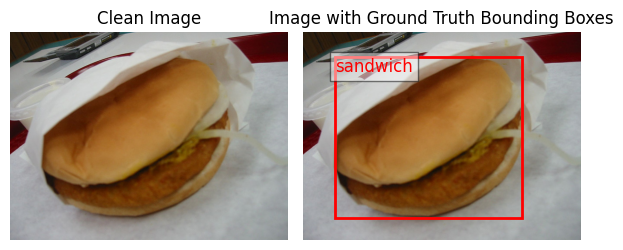

In [18]:
for sample in sandwich_dataset_one_label.head(3):
    preview_sample(sample, figsize=(6, 3))

### Prepare datset to work with tensorflow/keras

In [19]:
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(filepath, target_size=(299, 299)):
    img = load_img(filepath, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

X = []
y = []

for sample in pizza_set_one_label_3:
    img = load_and_preprocess_image(sample.filepath)
    X.append(img[0])
    y.append(0)  # 0 for pizza

for sample in sandwich_dataset_one_label:
    img = load_and_preprocess_image(sample.filepath)
    X.append(img[0])
    y.append(1)  # 1 for sandwich

X = np.array(X)
y = np.array(y)

In [20]:
np.save('data/X_pizza_sandwitch.npy', X)
np.save('data/y__pizza_sandwitch.npy', y)